In this notebook, I demonstrate the efficacy of inverse sinc weighting in subtracting foreground side-lobes associated with flagged channels.  

In [1]:
%matplotlib inline
from pyuvdata import UVData
import hera_pspec as hp
import numpy as np
import matplotlib.pyplot as plt
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
from hera_sim.simulate import Simulator
import hera_sim
from hera_sim import noise
import hera_pspec as hp

We will demonstrate the method on simulated visibilities generated by `hera_sim`.

In [2]:
dfile = os.path.join(DATA_PATH, 'zen.all.xx.LST.1.06964.uvA')
simulated_data = Simulator(dfile)
simulated_eor = Simulator(dfile)

simulated_data.data.data_array[:] = 0.+0j
simulated_eor.data.data_array[:] = 0.+0j

First, lets generate some random flags inside of our spectral windows (channels 300-400 and 600-721). These flags will generate nasty frequency side-lobes many orders of magnitude above the level of the signal. 

In [3]:
nflags = 15
for i in range(nflags):
    ind1 = np.random.randint(300,400)
    ind2 = np.random.randint(600,721)
    simulated_data.data.flag_array[:,:,ind1,:] = True
    simulated_data.data.flag_array[:,:,ind2,:] = True
    
    simulated_eor.data.flag_array[:,:,ind1,:] = True
    simulated_eor.data.flag_array[:,:,ind2,:] = True

Next, we generate some model visibilities comprising of mock EoR signal and foregrounds. 

In [4]:
Tsky_mdl = noise.HERA_Tsky_mdl['xx']


fg_model = lambda lsts, fqs, bl_vec: hera_sim.foregrounds.diffuse_foreground(lsts, fqs, bl_vec, Tsky_mdl)\
                                    +hera_sim.foregrounds.pntsrc_foreground(lsts, fqs, bl_vec)

noise_model = lambda lsts, fqs: noise.thermal_noise(lsts, fqs, Tsky_mdl)

eor_model = lambda lsts, fqs, bl_vec: hera_sim.eor.noiselike_eor(lsts, fqs, bl_vec, eor_amp = 3e-2)

simulated_eor.add_eor(eor_model)
simulated_data.data.data_array = copy.copy(simulated_eor.data.data_array)


simulated_data.add_foregrounds(fg_model)

uvd = simulated_data.data
uvd_eor = simulated_eor.data

## Set up our dspec object.

Now that we have simulated visibilities, we define a cosmology, load up a beam file, split the data into even and odd time steps, scale to mK units and create a delay spectrum object to read in the simulated data and perform the power spectrum calculations.

In [5]:
# Instantiate a Cosmo Conversions object
# we will need this cosmology to put the power spectra into cosmological units
cosmo = hp.conversions.Cosmo_Conversions()

# List of beamfile to load. This is a healpix map.
beamfile = os.path.join(DATA_PATH, 'HERA_NF_dipole_power.beamfits')

# intantiate beam and pass cosmology, if not fed, a default Planck cosmology will be assumed
uvb = hp.pspecbeam.PSpecBeamUV(beamfile, cosmo=cosmo)


# find conversion factor from Jy to mK
Jy_to_mK = uvb.Jy_to_mK(np.unique(uvd.freq_array), pol='XX')


# reshape to appropriately match a UVData.data_array object and multiply in!
uvd.data_array *= Jy_to_mK[None, None, :, None]
uvd_eor.data_array *= Jy_to_mK[None, None, :, None]

# slide the time axis of uvd by one integration
uvd1 = uvd.select(times=np.unique(uvd.time_array)[:-1:2], inplace=False)
uvd2 = uvd.select(times=np.unique(uvd.time_array)[1::2], inplace=False)


uvd_eor1 = uvd_eor.select(times=np.unique(uvd_eor.time_array)[:-1:2], inplace=False)
uvd_eor2 = uvd_eor.select(times=np.unique(uvd_eor.time_array)[1::2], inplace=False)


# Create a new PSpecData object, and don't forget to feed the beam object
ds = hp.PSpecData(dsets=[uvd1, uvd2], wgts=[None, None], beam=uvb)
ds_eor = hp.PSpecData(dsets=[uvd_eor1, uvd_eor2], wgts=[None, None], beam=uvb)


# Because the LST integrations are offset by more than ~15 seconds we will get a warning
# but this is okay b/c it is still **significantly** less than the beam-crossing time and we are using short
# baselines...

# here we phase all datasets in dsets to the zeroth dataset
ds.rephase_to_dset(0)
ds_eor.rephase_to_dset(0)

# change units of UVData objects
ds.dsets[0].vis_units = 'mK'
ds.dsets[1].vis_units = 'mK'

ds_eor.dsets[0].vis_units = 'mK'
ds_eor.dsets[1].vis_units = 'mK'

# Specify which baselines to include
baselines = [(24,25), (37,38), (38,39)]



### Construct an r_params dictionary.

`r_params` specifies the center, width, and level of each filtering window on each visibility. 

In [6]:

rp = {'filter_centers':[0.],
      'filter_half_widths':[250e-9],
      'filter_factors':[1e-9]}
    
r_params = {}

for bl in baselines:
    key1 = (0,) + bl + ('xx',)
    key2 = (1,) + bl + ('xx',)
    r_params[key1] = rp
    r_params[key2] = rp

To perform inverse sinc weighting, just set `input_data_weight='sinc_downweight'` and `r_params= r_params` when calling `pspecdata.pspec()`.

In [7]:
# we will use the baselines list to produce 3 power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across two spectral windows with identity weighting and a blackman-harris taper
uvp_isw = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (600,721)], 
               norm='I', taper='none', verbose=True,
               input_data_weight = 'sinc_downweight', r_params = r_params)


Setting spectral range: (300, 400)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 39), (38, 39))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37

We will compare the impact of filtering versus no filtering by creating an unfiltered `uvpspec` object, `uvp`. We also compare the filtered signal to the underlying 21cm signal by generating `uvp_eor` from visibilities that only contain the the 21cm realizations (no foregrounds). 

In [8]:
# we will use the baselines list to produce 3 power spectra
# whose data will be drawn from the dsets[0] and dsets[1]
# across two spectral windows with identity weighting and a blackman-harris taper
uvp = ds.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (600,721)], input_data_weight='identity',
               norm='I', taper='none', verbose=True)

uvp_eor = ds_eor.pspec(baselines, baselines, (0, 1), [('xx', 'xx')], spw_ranges=[(300, 400), (600,721)], input_data_weight='identity',
               norm='I', taper='none', verbose=True)


Setting spectral range: (300, 400)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((38, 39), (38, 39))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

Setting spectral range: (600, 721)

Using polarization pair: ('xx', 'xx')

(bl1, bl2) pair: ((24, 25), (24, 25))
pol: (-5, -5)
 which may lead to normalization instabilities.
  Building G...
  Building q_hat...
  Normalizing power spectrum...
  Computing and multiplying scalar...

(bl1, bl2) pair: ((37, 38), (37, 38))

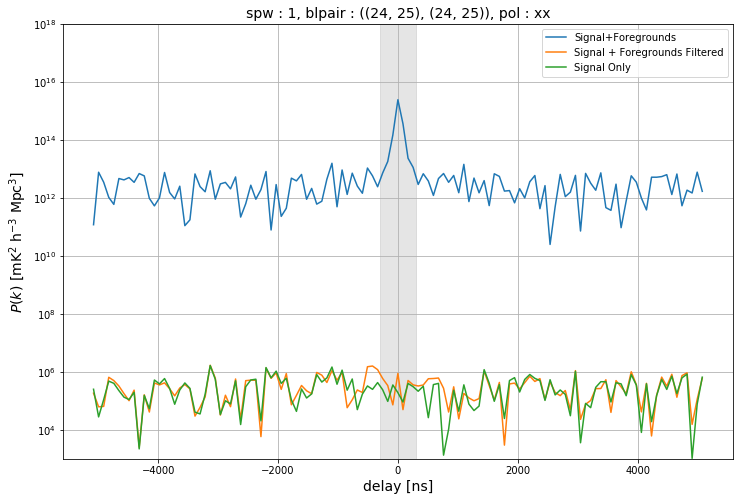

In [9]:
# plot power spectrum of spectral window 1
fig, ax = plt.subplots(figsize=(12,8))

plt.fill_between([-300,300],[1e-10,1e-10],[1e30,1e30],color='grey',alpha=.2)
spw = 1
blp =((24, 25), (24,25))
key = (spw, blp, 'xx')
dlys = uvp.get_dlys(spw) * 1e9
power = np.abs(np.real(uvp.get_data(key)))
power_isw = np.abs(np.real(uvp_isw.get_data(key)))
power_eor = np.abs(np.real(uvp_eor.get_data(key)))

p1 = ax.plot(dlys, power.mean(axis=0),label='Signal+Foregrounds')
p2 = ax.plot(dlys, power_isw.mean(axis=0), label='Signal + Foregrounds Filtered')
p2 = ax.plot(dlys, power_eor.mean(axis=0),label='Signal Only')

ax.set_yscale('log')
ax.grid()
ax.set_xlabel("delay [ns]", fontsize=14)
ax.set_ylabel(r"$P(k)\ \rm [mK^2\ h^{-3}\ Mpc^3]$", fontsize=14)
ax.set_title("spw : {}, blpair : {}, pol : {}".format(*key), fontsize=14)
plt.ylim(1e3,1e18)
plt.legend(loc='best')

Comparing the "Signal+Foregrounds" line in the above plot to the "Signal Only" line, we see that flagging side-lobes of the foregrounds dwarf the underlying signal by roughly nine orders of magnitude. When we apply inverse sinc filtering out to the width of the grey shaded region, we remove the foregrounds and their flagging side-lobes to a level where we recover an unbiased estimate of the 21cm signal. Rigorous studies of signal loss and residual biases are ongoing. 

In [10]:
print(uvp_isw.r_params)

{"0": {"filter_centers": [0.0], "filter_half_widths": [2.5e-07], "filter_factors": [1e-09], "baselines": [[0, 24, 25, "xx"], [1, 24, 25, "xx"], [0, 37, 38, "xx"], [1, 37, 38, "xx"], [0, 38, 39, "xx"], [1, 38, 39, "xx"]]}}
